In [17]:
import pandas as pd
import numpy as np
from collections import Counter 
import torchvision
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torch.autograd import Variable
from tqdm import tqdm
import matplotlib.pyplot as plt
import math
import torch.nn.functional as F
import pickle
import gc
import random
pd.set_option('display.max_colwidth', None)

In [3]:
df = pd.read_csv("./input/captions.txt", sep=',')
print(len(df))
display(df.head(3))

40455


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .


In [4]:
def remove_single_char_word(word_list):
    lst = []
    for word in word_list:
        if len(word)>1:
            lst.append(word)

    return lst

In [5]:
def clean_caption(caption):
    words = caption.split()
    cleaned = [word.lower() for word in words if word.isalpha() and len(word) > 1]
    return ['<start>'] + cleaned + ['<end>']

df['cleaned_caption'] = df['caption'].apply(clean_caption)


In [6]:
df['seq_len'] = df['cleaned_caption'].apply(lambda x : len(x))
max_seq_len = df['seq_len'].max()
print(max_seq_len)

33


In [7]:
df.drop(['seq_len'], axis = 1, inplace = True)
df['cleaned_caption'] = df['cleaned_caption'].apply(lambda caption : caption + ['<pad>']*(max_seq_len-len(caption)) )

In [8]:
display(df.head(2))

,image,caption,cleaned_caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .,"[<start>, child, in, pink, dress, is, climbing, up, set, of, stairs, in, an, entry, way, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]"
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,"[<start>, girl, going, into, wooden, building, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]"


In [9]:
word_list = df['cleaned_caption'].apply(lambda x : " ".join(x)).str.cat(sep = ' ').split(' ')
word_dict = Counter(word_list)
word_dict =  sorted(word_dict, key=word_dict.get, reverse=True)

In [10]:
print(len(word_dict))
print(word_dict[:5])

8360
['<pad>', '<start>', '<end>', 'in', 'the']


In [11]:
vocab_size = len(word_dict)
print(vocab_size)

8360


In [12]:
index_to_word = {index: word for index, word in enumerate(word_dict)}
word_to_index = {word: index for index, word in enumerate(word_dict)}
print(len(index_to_word), len(word_to_index))

8360 8360


In [13]:
df['text_seq']  = df['cleaned_caption'].apply(lambda caption : [word_to_index[word] for word in caption] )

In [14]:
display(df.head(2))

,image,caption,cleaned_caption,text_seq
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .,"[<start>, child, in, pink, dress, is, climbing, up, set, of, stairs, in, an, entry, way, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]","[1, 41, 3, 89, 168, 6, 118, 52, 392, 11, 389, 3, 27, 5075, 690, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,"[<start>, girl, going, into, wooden, building, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]","[1, 18, 311, 63, 192, 116, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [20]:
df = df.sort_values(by = 'image')
train = df.iloc[:int(0.9*len(df))]
valid = df.iloc[int(0.9*len(df)):]

In [21]:
print(len(train), train['image'].nunique())
print(len(valid), valid['image'].nunique())

36409 7282
4046 810


In [22]:
train_samples = len(train)
print(train_samples)

36409


In [23]:
unq_train_imgs = train[['image']].drop_duplicates()
unq_valid_imgs = valid[['image']].drop_duplicates()
print(len(unq_train_imgs), len(unq_valid_imgs))

7282 810


In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [18]:
class extractImageFeatureResNetDataSet():
    def __init__(self, data):
        self.data = data 
        self.scaler = transforms.Resize([224, 224])
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
        self.to_tensor = transforms.ToTensor()
    def __len__(self):  
        return len(self.data)

    def __getitem__(self, idx):

        image_name = self.data.iloc[idx]['image']
        img_loc = './input/Images/'+str(image_name)

        img = Image.open(img_loc)
        t_img = self.normalize(self.to_tensor(self.scaler(img)))

        return image_name, t_img

In [25]:
train_ImageDataset_ResNet = extractImageFeatureResNetDataSet(unq_train_imgs)
train_ImageDataloader_ResNet = DataLoader(train_ImageDataset_ResNet, batch_size = 1, shuffle=False)

In [26]:
valid_ImageDataset_ResNet = extractImageFeatureResNetDataSet(unq_valid_imgs)
valid_ImageDataloader_ResNet = DataLoader(valid_ImageDataset_ResNet, batch_size = 1, shuffle=False)

In [27]:
resnet18 = torchvision.models.resnet18(pretrained=True).to(device)
resnet18.eval()
list(resnet18._modules)

c:\Users\gauth\Desktop\Nidhi\AIT736\project\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\gauth\Desktop\Nidhi\AIT736\project\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


['conv1',
 'bn1',
 'relu',
 'maxpool',
 'layer1',
 'layer2',
 'layer3',
 'layer4',
 'avgpool',
 'fc']

In [28]:
resNet18Layer4 = resnet18._modules.get('layer4').to(device)

In [29]:
def get_vector(t_img):
    
    t_img = Variable(t_img)
    my_embedding = torch.zeros(1, 512, 7, 7)
    def copy_data(m, i, o):
        my_embedding.copy_(o.data)
    
    h = resNet18Layer4.register_forward_hook(copy_data)
    resnet18(t_img)
    
    h.remove()
    return my_embedding

In [58]:
extract_imgFtr_ResNet_train = {}
for image_name, t_img in tqdm(train_ImageDataloader_ResNet):
    t_img = t_img.to(device)
    embdg = get_vector(t_img)
    
    extract_imgFtr_ResNet_train[image_name[0]] = embdg

100%|██████████| 7282/7282 [05:27<00:00, 22.23it/s]


In [59]:
a_file = open("./EncodedImageTrainResNet.pkl", "wb")
pickle.dump(extract_imgFtr_ResNet_train, a_file)
a_file.close()

In [60]:
extract_imgFtr_ResNet_valid = {}
for image_name, t_img in tqdm(valid_ImageDataloader_ResNet):
    t_img = t_img.to(device)
    embdg = get_vector(t_img)
 
    extract_imgFtr_ResNet_valid[image_name[0]] = embdg

100%|██████████| 810/810 [00:48<00:00, 16.70it/s]


In [61]:
a_file = open("./EncodedImageValidResNet.pkl", "wb")
pickle.dump(extract_imgFtr_ResNet_valid, a_file)
a_file.close()

In [30]:
class FlickerDataSetResnet():
    def __init__(self, data, pkl_file):
        self.data = data
        self.encodedImgs = pd.read_pickle(pkl_file)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
    
        caption_seq = self.data.iloc[idx]['text_seq']
        target_seq = caption_seq[1:]+[0]

        image_name = self.data.iloc[idx]['image']
        image_tensor = self.encodedImgs[image_name]
        image_tensor = image_tensor.permute(0,2,3,1)
        image_tensor_view = image_tensor.view(image_tensor.size(0), -1, image_tensor.size(3))

        return torch.tensor(caption_seq), torch.tensor(target_seq), image_tensor_view

In [31]:
train_dataset_resnet = FlickerDataSetResnet(train, 'EncodedImageTrainResNet.pkl')
train_dataloader_resnet = DataLoader(train_dataset_resnet, batch_size = 32, shuffle=True)

In [32]:
valid_dataset_resnet = FlickerDataSetResnet(valid, 'EncodedImageValidResNet.pkl')
valid_dataloader_resnet = DataLoader(valid_dataset_resnet, batch_size = 32, shuffle=True)

In [33]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=max_seq_len):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        

    def forward(self, x):
        if self.pe.size(0) < x.size(0):
            self.pe = self.pe.repeat(x.size(0), 1, 1).to(device)
        self.pe = self.pe[:x.size(0), : , : ]
        
        x = x + self.pe
        return self.dropout(x)

In [34]:
class ImageCaptionModel(nn.Module):
    def __init__(self, n_head, n_decoder_layer, vocab_size, embedding_size):
        super(ImageCaptionModel, self).__init__()
        self.pos_encoder = PositionalEncoding(embedding_size, 0.1)
        self.TransformerDecoderLayer = nn.TransformerDecoderLayer(d_model =  embedding_size, nhead = n_head)
        self.TransformerDecoder = nn.TransformerDecoder(decoder_layer = self.TransformerDecoderLayer, num_layers = n_decoder_layer)
        self.embedding_size = embedding_size
        self.embedding = nn.Embedding(vocab_size , embedding_size)
        self.last_linear_layer = nn.Linear(embedding_size, vocab_size)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.last_linear_layer.bias.data.zero_()
        self.last_linear_layer.weight.data.uniform_(-initrange, initrange)

    def generate_Mask(self, size, decoder_inp):
        decoder_input_mask = (torch.triu(torch.ones(size, size)) == 1).transpose(0, 1)
        decoder_input_mask = decoder_input_mask.float().masked_fill(decoder_input_mask == 0, float('-inf')).masked_fill(decoder_input_mask == 1, float(0.0))

        decoder_input_pad_mask = decoder_inp.float().masked_fill(decoder_inp == 0, float(0.0)).masked_fill(decoder_inp > 0, float(1.0))
        decoder_input_pad_mask_bool = decoder_inp == 0

        return decoder_input_mask, decoder_input_pad_mask, decoder_input_pad_mask_bool

    def forward(self, encoded_image, decoder_inp):
        encoded_image = encoded_image.permute(1,0,2)
        

        decoder_inp_embed = self.embedding(decoder_inp)* math.sqrt(self.embedding_size)
        
        decoder_inp_embed = self.pos_encoder(decoder_inp_embed)
        decoder_inp_embed = decoder_inp_embed.permute(1,0,2)
        

        decoder_input_mask, decoder_input_pad_mask, decoder_input_pad_mask_bool = self.generate_Mask(decoder_inp.size(1), decoder_inp)
        decoder_input_mask = decoder_input_mask.to(device)
        decoder_input_pad_mask = decoder_input_pad_mask.to(device)
        decoder_input_pad_mask_bool = decoder_input_pad_mask_bool.to(device)
        

        decoder_output = self.TransformerDecoder(tgt = decoder_inp_embed, memory = encoded_image, tgt_mask = decoder_input_mask, tgt_key_padding_mask = decoder_input_pad_mask_bool)
        
        final_output = self.last_linear_layer(decoder_output)

        return final_output,  decoder_input_pad_mask

In [67]:
EPOCH = 30

In [69]:
ictModel = ImageCaptionModel(16, 4, vocab_size, 512).to(device)
optimizer = torch.optim.Adam(ictModel.parameters(), lr = 0.00001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.8, patience=2, verbose = True)
criterion = torch.nn.CrossEntropyLoss(reduction='none')
min_val_loss = np.float64('inf') 

In [70]:
for epoch in tqdm(range(EPOCH)):
    total_epoch_train_loss = 0
    total_epoch_valid_loss = 0
    total_train_words = 0
    total_valid_words = 0
    ictModel.train()

    ### Train Loop
    for caption_seq, target_seq, image_embed in train_dataloader_resnet:

        optimizer.zero_grad()

        image_embed = image_embed.squeeze(1).to(device)
        caption_seq = caption_seq.to(device)
        target_seq = target_seq.to(device)

        output, padding_mask = ictModel.forward(image_embed, caption_seq)
        output = output.permute(1, 2, 0)

        loss = criterion(output,target_seq)

        loss_masked = torch.mul(loss, padding_mask)

        final_batch_loss = torch.sum(loss_masked)/torch.sum(padding_mask)

        final_batch_loss.backward()
        optimizer.step()
        total_epoch_train_loss += torch.sum(loss_masked).detach().item()
        total_train_words += torch.sum(padding_mask)

 
    total_epoch_train_loss = total_epoch_train_loss/total_train_words
  

    ### Eval Loop
    ictModel.eval()
    with torch.no_grad():
        for caption_seq, target_seq, image_embed in valid_dataloader_resnet:

            image_embed = image_embed.squeeze(1).to(device)
            caption_seq = caption_seq.to(device)
            target_seq = target_seq.to(device)

            output, padding_mask = ictModel.forward(image_embed, caption_seq)
            output = output.permute(1, 2, 0)

            loss = criterion(output,target_seq)

            loss_masked = torch.mul(loss, padding_mask)

            total_epoch_valid_loss += torch.sum(loss_masked).detach().item()
            total_valid_words += torch.sum(padding_mask)

    total_epoch_valid_loss = total_epoch_valid_loss/total_valid_words
  
    print("Epoch -> ", epoch," Training Loss -> ", total_epoch_train_loss.item(), "Eval Loss -> ", total_epoch_valid_loss.item() )
  
    if min_val_loss > total_epoch_valid_loss:
        print("Writing Model at epoch ", epoch)
        torch.save(ictModel, './BestModel')
        min_val_loss = total_epoch_valid_loss
  

    scheduler.step(total_epoch_valid_loss.item())

  0%|          | 0/30 [00:00<?, ?it/s]c:\Users\gauth\Desktop\Nidhi\AIT736\project\venv\Lib\site-packages\torch\nn\functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
  3%|▎         | 1/30 [08:45<4:14:06, 525.73s/it]

Epoch ->  0  Training Loss ->  5.34312629699707 Eval Loss ->  4.406877040863037
Writing Model at epoch  0


  7%|▋         | 2/30 [16:06<3:42:04, 475.86s/it]

Epoch ->  1  Training Loss ->  4.239728927612305 Eval Loss ->  4.002049922943115
Writing Model at epoch  1


 10%|█         | 3/30 [23:28<3:27:09, 460.34s/it]

Epoch ->  2  Training Loss ->  3.9248831272125244 Eval Loss ->  3.809096336364746
Writing Model at epoch  2


 13%|█▎        | 4/30 [30:50<3:16:18, 453.00s/it]

Epoch ->  3  Training Loss ->  3.7293827533721924 Eval Loss ->  3.6868836879730225
Writing Model at epoch  3


 17%|█▋        | 5/30 [43:33<3:55:21, 564.88s/it]

Epoch ->  4  Training Loss ->  3.584066152572632 Eval Loss ->  3.590686798095703
Writing Model at epoch  4


 20%|██        | 6/30 [50:54<3:29:09, 522.90s/it]

Epoch ->  5  Training Loss ->  3.467956304550171 Eval Loss ->  3.5168981552124023
Writing Model at epoch  5


 23%|██▎       | 7/30 [58:43<3:13:38, 505.15s/it]

Epoch ->  6  Training Loss ->  3.3689334392547607 Eval Loss ->  3.46604061126709
Writing Model at epoch  6


 27%|██▋       | 8/30 [1:06:02<2:57:29, 484.08s/it]

Epoch ->  7  Training Loss ->  3.2821662425994873 Eval Loss ->  3.420034885406494
Writing Model at epoch  7


 30%|███       | 9/30 [1:13:18<2:44:10, 469.05s/it]

Epoch ->  8  Training Loss ->  3.2073776721954346 Eval Loss ->  3.380352020263672
Writing Model at epoch  8


 33%|███▎      | 10/30 [1:20:35<2:33:00, 459.05s/it]

Epoch ->  9  Training Loss ->  3.1381373405456543 Eval Loss ->  3.352194309234619
Writing Model at epoch  9


 37%|███▋      | 11/30 [1:32:07<2:47:59, 530.50s/it]

Epoch ->  10  Training Loss ->  3.074704647064209 Eval Loss ->  3.3258872032165527
Writing Model at epoch  10


 40%|████      | 12/30 [1:39:23<2:30:29, 501.66s/it]

Epoch ->  11  Training Loss ->  3.015282392501831 Eval Loss ->  3.3021204471588135
Writing Model at epoch  11


 43%|████▎     | 13/30 [1:46:35<2:16:12, 480.71s/it]

Epoch ->  12  Training Loss ->  2.961179733276367 Eval Loss ->  3.2872886657714844
Writing Model at epoch  12


 47%|████▋     | 14/30 [2:06:38<3:06:20, 698.78s/it]

Epoch ->  13  Training Loss ->  2.908053159713745 Eval Loss ->  3.267085552215576
Writing Model at epoch  13


 50%|█████     | 15/30 [2:14:16<2:36:33, 626.23s/it]

Epoch ->  14  Training Loss ->  2.8584890365600586 Eval Loss ->  3.2546660900115967
Writing Model at epoch  14


 53%|█████▎    | 16/30 [2:31:24<2:54:20, 747.21s/it]

Epoch ->  15  Training Loss ->  2.811401844024658 Eval Loss ->  3.243910551071167
Writing Model at epoch  15


 57%|█████▋    | 17/30 [2:44:35<2:44:41, 760.15s/it]

Epoch ->  16  Training Loss ->  2.76684308052063 Eval Loss ->  3.233712911605835
Writing Model at epoch  16


 60%|██████    | 18/30 [2:52:09<2:13:40, 668.41s/it]

Epoch ->  17  Training Loss ->  2.7224507331848145 Eval Loss ->  3.2236523628234863
Writing Model at epoch  17


 63%|██████▎   | 19/30 [2:59:34<1:50:11, 601.07s/it]

Epoch ->  18  Training Loss ->  2.6804826259613037 Eval Loss ->  3.2233760356903076
Writing Model at epoch  18


 67%|██████▋   | 20/30 [3:07:00<1:32:26, 554.66s/it]

Epoch ->  19  Training Loss ->  2.639308452606201 Eval Loss ->  3.2128279209136963
Writing Model at epoch  19


 70%|███████   | 21/30 [3:14:26<1:18:17, 521.89s/it]

Epoch ->  20  Training Loss ->  2.5989818572998047 Eval Loss ->  3.210845947265625
Writing Model at epoch  20


 73%|███████▎  | 22/30 [3:21:43<1:06:12, 496.62s/it]

Epoch ->  21  Training Loss ->  2.5609734058380127 Eval Loss ->  3.2091751098632812
Writing Model at epoch  21


 77%|███████▋  | 23/30 [3:28:59<55:49, 478.48s/it]  

Epoch ->  22  Training Loss ->  2.5230062007904053 Eval Loss ->  3.2052788734436035
Writing Model at epoch  22


 80%|████████  | 24/30 [3:42:05<57:03, 570.58s/it]

Epoch ->  23  Training Loss ->  2.486433506011963 Eval Loss ->  3.2035107612609863
Writing Model at epoch  23
Epoch ->  24  Training Loss ->  2.449766159057617 Eval Loss ->  3.2010104656219482
Writing Model at epoch  24


 83%|████████▎ | 25/30 [4:07:41<1:11:40, 860.15s/it]

Epoch ->  25  Training Loss ->  2.414999485015869 Eval Loss ->  3.200730085372925
Writing Model at epoch  25


 90%|█████████ | 27/30 [5:35:26<1:27:42, 1754.15s/it]

Epoch ->  26  Training Loss ->  2.3806285858154297 Eval Loss ->  3.20800518989563


 93%|█████████▎| 28/30 [5:45:03<46:41, 1400.94s/it]  

Epoch ->  27  Training Loss ->  2.3465962409973145 Eval Loss ->  3.2032670974731445


 97%|█████████▋| 29/30 [6:10:17<23:54, 1434.73s/it]

Epoch ->  28  Training Loss ->  2.3084933757781982 Eval Loss ->  3.204768419265747


100%|██████████| 30/30 [6:18:23<00:00, 756.78s/it] 

Epoch ->  29  Training Loss ->  2.2823615074157715 Eval Loss ->  3.2056515216827393


In [73]:
torch.save(ictModel.state_dict(), 'resent_transformer.pth')

In [35]:
# Rebuild model
model = ImageCaptionModel(n_head=16, n_decoder_layer=4, vocab_size=vocab_size, embedding_size=512).to(device)

# Load model weights but ignore positional encoding mismatch
state_dict = torch.load('resent_transformer.pth', map_location=device)

# Remove 'pos_encoder.pe' from the loaded state_dict
state_dict = {k: v for k, v in state_dict.items() if 'pos_encoder.pe' not in k}

# Load the cleaned state dict
model.load_state_dict(state_dict, strict=False)
model.eval()


ImageCaptionModel(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (TransformerDecoderLayer): TransformerDecoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
    )
    (multihead_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
    )
    (linear1): Linear(in_features=512, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=512, bias=True)
    (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (norm3): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
    (dropout3): Dropout(p=0.1, inplace=False)
  )
  (TransformerDecoder): Transfor

In [36]:
start_token = word_to_index['<start>']
end_token = word_to_index['<end>']
pad_token = word_to_index['<pad>']
max_seq_len = 33
print(start_token, end_token, pad_token)

1 2 0


In [37]:
valid_img_embed = pd.read_pickle('EncodedImageValidResNet.pkl')

In [38]:
def generate_caption(K, img_nm): 
    img_loc = './input/Images/'+str(img_nm)
    image = Image.open(img_loc).convert("RGB")
    plt.imshow(image)

    model.eval() 
    valid_img_df = valid[valid['image']==img_nm]
    print("Actual Caption : ")
    print(valid_img_df['caption'].tolist())
    img_embed = valid_img_embed[img_nm].to(device)


    img_embed = img_embed.permute(0,2,3,1)
    img_embed = img_embed.view(img_embed.size(0), -1, img_embed.size(3))


    input_seq = [pad_token]*max_seq_len
    input_seq[0] = start_token

    input_seq = torch.tensor(input_seq).unsqueeze(0).to(device)
    predicted_sentence = []
    with torch.no_grad():
        for eval_iter in range(0, max_seq_len):

            output, padding_mask = model.forward(img_embed, input_seq)

            output = output[eval_iter, 0, :]

            values = torch.topk(output, K).values.tolist()
            indices = torch.topk(output, K).indices.tolist()

            next_word_index = random.choices(indices, values, k = 1)[0]

            next_word = index_to_word[next_word_index]

            input_seq[:, eval_iter+1] = next_word_index


            if next_word == '<end>' :
                break

            predicted_sentence.append(next_word)
    print("\n")
    print("Predicted caption : ")
    print(" ".join(predicted_sentence+['.']))

Actual Caption : 
['Brown dog leaping up with orange disc in mouth with blue and yellow toy boat in background .', 'A dog leaping to catch a Frisbee in the yard .', 'A dog is jumping in the air to catch an orange Frisbee .', 'A brown dog leaps up to catch an orange toy .', 'A dog catches a disk in the air .']


Predicted caption : 
dog jumping over hurdle in the air to catch ball .


c:\Users\gauth\Desktop\Nidhi\AIT736\project\venv\Lib\site-packages\torch\nn\functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


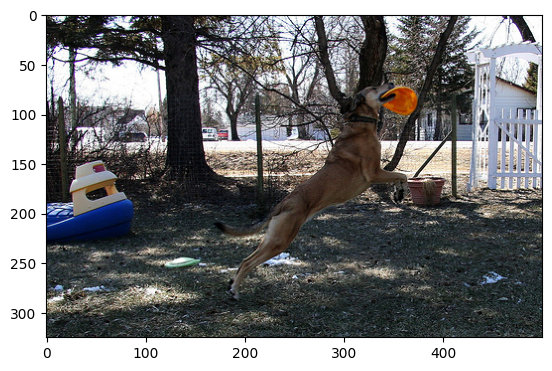

In [39]:
generate_caption(1, unq_valid_imgs.iloc[55]['image'])

Actual Caption : 
['A dog is walking near a body of water .', "A big , black dog is walking along the water 's edge .", 'A black dog and its reflection are seen near a pond ringed by dry foliage .', 'A black dog is walking beside water in the woods .', "A black dog walks along a marsh 's edge ."]


Predicted caption : 
dog jumping over log in the river with trees in the foreground and river .


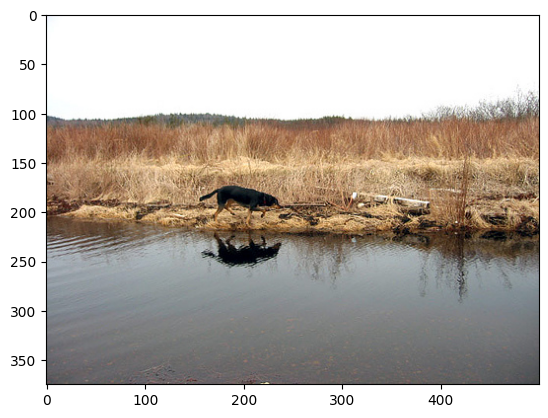

In [88]:
generate_caption(2, unq_valid_imgs.iloc[88]['image'])

Actual Caption : 
['A curly haired dog tries to bite another dog wearing a green and orange collar .', 'One brown dog is bearing its teeth at another brown dog with a green collar in a park .', 'Two brown dogs playing .', 'Two dogs , one with its mouth open .', 'Two golden dogs playing with one another']


Predicted caption : 
brown dog is running with blue toy .


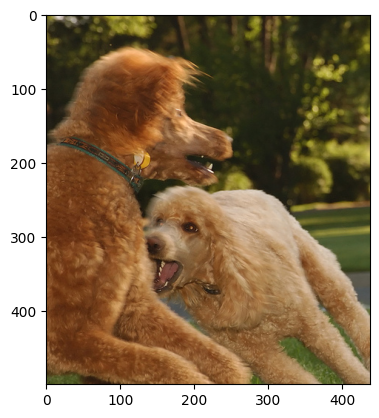

In [41]:
generate_caption(2, unq_valid_imgs.iloc[500]['image'])

Actual Caption : 
['A distant person is climbing up a very sheer mountain .', 'A panoramic distance view of a rock climber going up a steep mountain wall .', 'person rock climbing', 'There is a person scaling a very steep rock wall .', 'This person is climbing the side of a mountain .']


Predicted caption : 
person in black jacket and black is standing on cliff overlooking the water below of large waterfall with mountain .


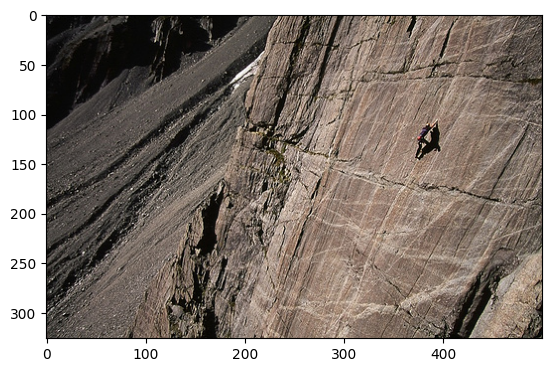

In [42]:
generate_caption(2, unq_valid_imgs.iloc[100]['image'])

In [15]:
import pickle

# Save word_to_index
with open("word_to_index.pkl", "wb") as f:
    pickle.dump(word_to_index, f)

# Save index_to_word
with open("index_to_word.pkl", "wb") as f:
    pickle.dump(index_to_word, f)
